In [444]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import plotly.graph_objects as go

import random
import pandas as pd
import numpy as np

!pip install torchinfo
from torchinfo import summary

In [445]:
# Random Seed 고정 (학습 반복 시행 시에도 동일한 결과가 나오도록)

seed = 20250309

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

**1. 데이터셋 로딩 및 데이터 분석**

In [446]:
# 데이터셋 로딩

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transform,
                                          download=True)


In [447]:
# 시간 절약을 위해, 학습 데이터에서 랜덤하게 일부 샘플만 추출

from torch.utils.data import Subset, DataLoader

NUM_TRAIN_SAMPLES = 7500
BATCH_SIZE = 32

subset_indices = random.sample(range(len(train_dataset)), NUM_TRAIN_SAMPLES)
train_subset = Subset(train_dataset, subset_indices)

train_loader = DataLoader(train_subset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

# 테스트 데이터셋은 학습 대상이 아니므로 그대로 이용
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

In [448]:
# 클래스 불균형 분석

# 학습 데이터
train_labels = torch.tensor([train_subset.dataset.targets[i] for i in subset_indices])
train_class_counts = torch.bincount(train_labels)
print(train_class_counts)

NUM_CLASSES = len(train_class_counts)

tensor([714, 899, 747, 743, 761, 655, 729, 789, 678, 785])


In [449]:
train_class_percentage = np.array(train_class_counts) * 100.0 / sum(train_class_counts)

train_y_distrib = pd.DataFrame({'class': list(range(NUM_CLASSES)),
                                'count': train_class_counts,
                                'percentage (%)': train_class_percentage})

train_y_distrib

,class,count,percentage (%)
0,0,714,9.520000
1,1,899,11.986667
2,2,747,9.960000
3,3,743,9.906667
4,4,761,10.146667
5,5,655,8.733333
6,6,729,9.720000
7,7,789,10.520000
8,8,678,9.040000
9,9,785,10.466667


In [450]:
# 테스트 데이터
test_labels = test_loader.dataset.targets
test_class_counts = torch.bincount(test_labels)
print(test_class_counts)

tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])


In [451]:
test_class_percentage = np.array(test_class_counts) * 100.0 / sum(test_class_counts)

test_y_distrib = pd.DataFrame({'class': list(range(NUM_CLASSES)),
                               'count': test_class_counts,
                               'percentage (%)': test_class_percentage})

test_y_distrib

,class,count,percentage (%)
0,0,980,9.80
1,1,1135,11.35
2,2,1032,10.32
3,3,1010,10.10
4,4,982,9.82
5,5,892,8.92
6,6,958,9.58
7,7,1028,10.28
8,8,974,9.74
9,9,1009,10.09


In [452]:
# CNN 모델 정의

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        # Conv
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU()
        )

        # Fully Connected
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 4 * 4, 256),
            nn.Sigmoid()
        )
        self.fc_final = nn.Sequential(
            nn.Linear(256, 10),
            nn.Softmax()  # Classification Task 의 Output Layer 이므로 Softmax 고정
        )

    def forward(self, x):

        # Conv
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool2(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(-1, 256 * 4 * 4)

        # Fully Connected
        x = self.fc1(x)
        x = self.fc_final(x)

        return x

In [453]:
# 모델 구조 출력

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

print(summary(model, input_size=(BATCH_SIZE, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 28, 28]          --
│    └─Conv2d: 2-1                       [32, 32, 28, 28]          320
│    └─ReLU: 2-2                         [32, 32, 28, 28]          --
├─MaxPool2d: 1-2                         [32, 32, 14, 14]          --
├─Sequential: 1-3                        [32, 64, 14, 14]          --
│    └─Conv2d: 2-3                       [32, 64, 14, 14]          18,496
│    └─ReLU: 2-4                         [32, 64, 14, 14]          --
├─Sequential: 1-4                        [32, 64, 12, 12]          --
│    └─Conv2d: 2-5                       [32, 64, 12, 12]          36,928
│    └─ReLU: 2-6                         [32, 64, 12, 12]          --
├─MaxPool2d: 1-5                         [32, 64, 6, 6]            --
├─Sequential: 1-6                        [32, 128, 6, 6]           --
│    └

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1844: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



**3. 데이터셋 분리**

* Train Data -> Train Data + Valid Data (epoch) + Valid Data (하이퍼파라미터 최적화)

In [454]:
# 데이터셋 분리

from torch.utils.data import random_split

# 샘플 수
num_train = 500
num_valid_epoch = 2000
num_valid_hpo = 5000

assert NUM_TRAIN_SAMPLES == num_train + num_valid_epoch + num_valid_hpo

# 데이터셋 분리
train_dataset, valid_epoch_dataset, valid_hpo_dataset =\
    random_split(train_subset, [num_train, num_valid_epoch, num_valid_hpo])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_epoch_loader = DataLoader(valid_epoch_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_hpo_loader = DataLoader(valid_hpo_dataset, batch_size=BATCH_SIZE, shuffle=False)

**4. 하이퍼파라미터 최적화 학습 실시 함수**

* 하이퍼파라미터 최적화 라이브러리는 Optuna 사용
* 하이퍼파라미터 탐색 150 회 실시
* 하이퍼파라미터 목록
  * Augmentation Type
  * Augmentation 적용 확률
  * Augmentation 적용 강도
  * Learning Rate
    * 0.0001 ~ 0.003 (= 1e-4 ~ 3e-3) 범위


In [455]:
MAX_EPOCHS = 65536
TRIAL_COUNT = 150           # HPO trial count
EARLY_STOPPING_ROUNDS = 10  # Early Stopping epoch count

In [456]:
from sklearn.metrics import accuracy_score
from copy import deepcopy

In [457]:
# Optuna 설정

!pip install optuna
import optuna
import logging

optuna.logging.set_verbosity(logging.WARNING)

In [458]:
# Augmentation Mode 및 확률, 강도에 따른 transformation 적용

from torch.utils.data import Dataset
from torchvision.transforms import v2

IMAGE_SIZE = 28
PADDING_SIZE = IMAGE_SIZE - 1

class TransformedDataset(Dataset):
    def __init__(self, dataset, aug_type, aug_prob, aug_degree):
        self.dataset = dataset
        self.aug_type = aug_type
        self.aug_prob = aug_prob
        self.aug_degree = aug_degree

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        # 이미지 형태 기하학적 변환
        if self.aug_type == 'geometric':

            # rotation (NOT APPLIED for this experiment)
            transform_rotation = v2.Compose([
                v2.RandomRotation(degrees=(- (self.aug_degree * 180.0), self.aug_degree * 180.0)),
                v2.Pad(padding=PADDING_SIZE, padding_mode='reflect')  # reflect padding 적용
            ])
            transform_rotation = v2.RandomApply([transform_rotation],
                                                p=self.aug_prob)

            # affine (NOT APPLIED for this experiment)
            transform_affine = v2.Compose([
                v2.RandomAffine(degrees=(0, 0),
                                translate=(0, self.aug_degree),
                                shear=self.aug_degree * 90.0),
                v2.Pad(padding=PADDING_SIZE, padding_mode='reflect')  # reflect padding 적용
            ])
            transform_affine = v2.RandomApply([transform_affine],
                                              p=self.aug_prob)

            # transform
            crop_size = int(round((1.0 - 0.5 * self.aug_degree) * IMAGE_SIZE))

            aug_transform = v2.Compose([
                v2.RandomVerticalFlip(p=0.5 * self.aug_prob),
                v2.RandomHorizontalFlip(p=0.5 * self.aug_prob),
#                transform_rotation,
                v2.RandomApply([v2.RandomCrop(size=(crop_size, crop_size))], p=self.aug_prob),
                v2.RandomApply([v2.CenterCrop(size=(crop_size, crop_size))], p=self.aug_prob),
                v2.Resize(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=True)
            ])

        # 이미지 색상 변환
        elif self.aug_type == 'color':

            # ColorJitter
            transform_colorjitter = v2.ColorJitter(
                brightness=(1.0 - self.aug_degree, 1.0 + 2.0 * self.aug_degree),
                contrast=(1.0 - self.aug_degree, 1.0 + 2.0 * self.aug_degree),
                saturation=(1.0 - self.aug_degree, 1.0 + 2.0 * self.aug_degree)
            )
            transform_colorjitter = v2.RandomApply([transform_colorjitter],
                                                   p=self.aug_prob)

            # transform
            aug_transform = v2.Compose([
                transform_colorjitter,
                v2.RandomGrayscale(p=0.5 * self.aug_prob),
                v2.RandomInvert(p=0.5 * self.aug_prob)
            ])

        transformed_image = aug_transform(image)

        return transformed_image, label

In [459]:
# 데이터셋의 이미지 확인 (깔끔한 시각적 효과는 불필요하므로 Matplotlib 사용)

import matplotlib.pyplot as plt

def check_images(data_loader, limit=10):
    for idx, (images, labels) in enumerate(data_loader):

        # check limit
        if idx >= limit:
            return

        # display images in batch
        row_length = len(images)

        fig, axes = plt.subplots(1, row_length,
                                 figsize=(row_length * 0.4, 0.4))

        for i in range(row_length):
            img = images[i].numpy().transpose((1, 2, 0))  # (C,H,W) to (H,W,C)
            axes[i].imshow(img)
            axes[i].axis('off')

        plt.imshow(img)
        plt.show()

In [460]:
# transformation (augmentation) 적용된 데이터셋 가져오기

def get_transformed_dataset(train_loader, params):
    return DataLoader(TransformedDataset(train_loader.dataset,
                                         aug_type=params['aug_type'],
                                         aug_prob=params['aug_prob'],
                                         aug_degree=params['aug_degree']),
                      batch_size=BATCH_SIZE,
                      shuffle=True)

In [461]:
# check images before main experiment

params = {'aug_type': 'geometric', 'aug_prob': 0.75, 'aug_degree': 0.75}
train_loader_aug = get_transformed_dataset(train_loader, params)
train_loader_augmented_dataset = torch.utils.data.ConcatDataset([train_loader.dataset,
                                                                 train_loader_aug.dataset])

train_loader_ = DataLoader(train_loader_augmented_dataset,
                           batch_size=BATCH_SIZE,
                           shuffle=True)

print(len(train_loader_.dataset))

1000


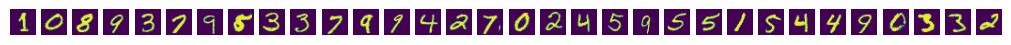

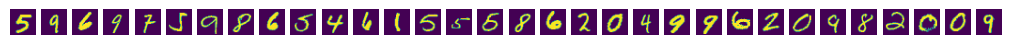

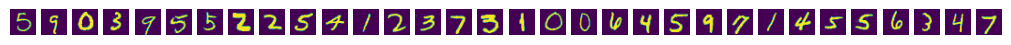

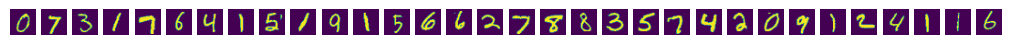

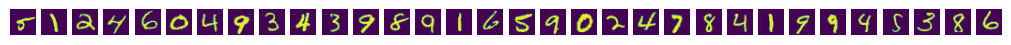

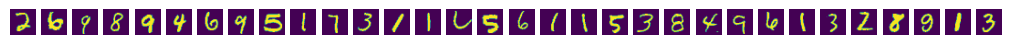

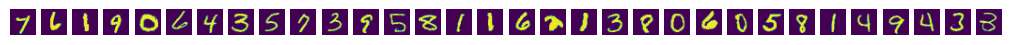

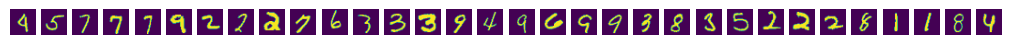

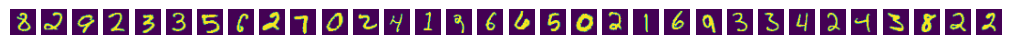

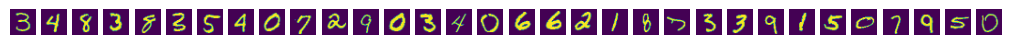

In [462]:
# 원본

check_images(train_loader)

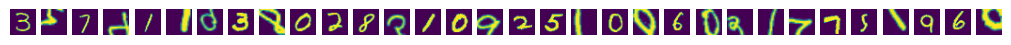

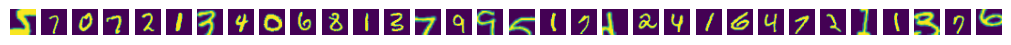

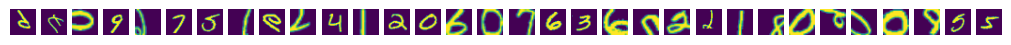

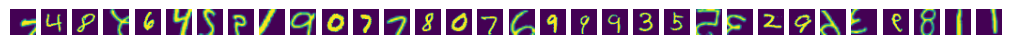

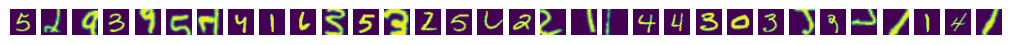

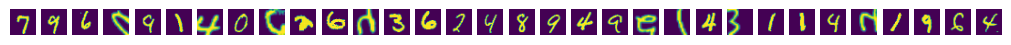

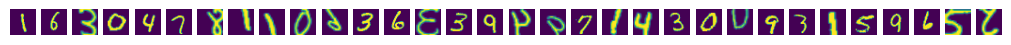

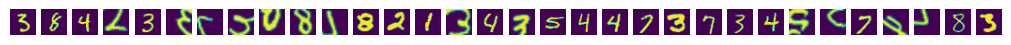

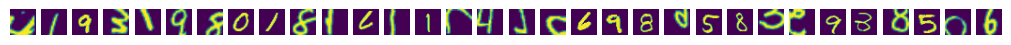

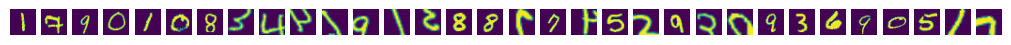

In [463]:
# 원본 + Augmented

check_images(train_loader_)

In [464]:
# 모델 학습 실시

# args :
# - model           : 학습할 모델
# - train_loader    : Training Data Loader
# - train_loss_list : 각 epoch 에서의 train loss 기록

# returns :
# - train_loss : 모델의 Train Loss

def run_train(model, train_loader, train_loss_list):
    model.train()
    train_loss = 0.0
    cnt = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # train 실시
        model.optimizer.zero_grad()
        outputs = model(images)

        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        model.optimizer.step()

        train_loss += loss.item()
        cnt += 1

    train_loss_list.append(train_loss / len(train_loader))
    return train_loss_list[-1]

In [465]:
# 모델 validation 실시

# args :
# - model        : validation 할 모델
# - valid_loader : Validation Data Loader
# - during_train : 모델 학습 중이면 True, 그렇지 않으면 False

# returns :
# - val_accuracy : 모델의 validation 정확도
# - val_loss     : 모델의 validation loss

def run_validation(model, valid_loader, during_train=True):
    model.eval()
    correct, total = 0, 0
    val_loss_sum = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss_batch = nn.CrossEntropyLoss(reduction='sum')(outputs, labels)
            val_loss_sum += val_loss_batch

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Accuracy 계산
        val_accuracy = correct / total
        val_loss = val_loss_sum / total

    return val_accuracy, val_loss

In [466]:
# 모델 학습 및 validation 전체 프로세스

# args :
# - model              : 학습할 모델
# - train_loader       : Training Data Loader
# - valid_epoch_loader : 각 epoch 마다 validation 할 Valid Data Loader
# - valid_hpo_loader   : 최종적으로 해당 하이퍼파라미터 조합에 대한 Valid Data Loader
# - verbose            : 학습 중 프로세스 출력 여부

# returns :
# - final_acc        : 해당 하이퍼파라미터 조합에 대한 최종 Accuracy (valid accuracy 가 가장 높았던 epoch 의 모델로 측정)
# - best_epoch_model : valid accuracy 가 가장 높았던 epoch 에서 생성된 모델
# - epochs           : 해당 학습의 총 epoch count

def run_model_common(model, train_loader, valid_epoch_loader, valid_hpo_loader,
                     verbose=False):

    train_loss_list = []        # train loss
    valid_acc_list = []         # valid accuracy
    valid_loss_list = []        # valid loss

    max_valid_acc = 0.0         # max validation accuracy
    min_valid_loss = None       # min validation loss

    best_valid_acc_epoch = -1   # valid accuracy 가 가장 높았던 epoch
    best_valid_loss_epoch = -1  # valid loss 가 가장 낮았던 epoch
    best_epoch_model = None     # valid accuracy 가 가장 높았던 epoch 의 모델

    # 1. 학습 실시
    for epoch in range(MAX_EPOCHS):

        # 1-1. train model
        train_loss = run_train(model, train_loader, train_loss_list)

        # 1-2. validate model (with EPOCH VALID SET)
        epoch_acc, val_loss = run_validation(model, valid_epoch_loader)
        valid_acc_list.append(epoch_acc)
        valid_loss_list.append(val_loss)

        # 1-3. Early Stopping 처리 (overfitting 방지)
        if epoch_acc > max_valid_acc:
            max_valid_acc = epoch_acc
            best_valid_acc_epoch = epoch

            best_epoch_model = CNN().to(device)
            best_epoch_model.load_state_dict(model.state_dict())

            if verbose:
                print('best model updated')

        # Early Stopping 학습 종료
        if epoch - best_valid_acc_epoch >= EARLY_STOPPING_ROUNDS:
            epochs = epoch
            break

        # 1-4. 결과 출력
        if verbose:
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}, Valid Accuracy: {epoch_acc:.4f}")

    # check best-epoch model correctly loaded
    checked_acc, _ = run_validation(best_epoch_model,
                                    valid_epoch_loader,
                                    during_train=False)

    if verbose:
        print(f"Best Epoch: {best_valid_acc_epoch}, Best Valid Acc: {max_valid_acc}")
        print(f"Valid Acc (with Epoch valid set) on Loaded Best Model: {checked_acc}")

    assert abs(max_valid_acc - checked_acc) < 1e-8

    # 2. validate best-epoch model (with HPO VALID SET)
    final_acc, _ = run_validation(best_epoch_model,
                                  valid_hpo_loader,
                                  during_train=False)

    if verbose:
        print(f"Final Acc (with HPO valid set) on Loaded Best Model: {final_acc}")

    return final_acc, best_epoch_model, epochs

In [467]:
print(device)

cuda


**4-1. 실험 실시**

In [468]:
hpo_best_acc = 0              # 모든 Hyper-param 조합의 HPO Valid set 정확도 중 가장 높은 것
best_hyperparam_set = None    # HPO Valid set 정확도가 가장 높은 Hyper-param 조합
best_hyperparam_model = None  # best_hyperparam_set 의 Hyper-param 조합으로 학습된 모델

In [469]:
trial_count = 0   # 1st ~ 10th trial 에만 학습 중 정보 출력
epoch_count = []  # 각 trial 의 epoch 횟수 리스트

def objective(trial):
    global hpo_best_acc, best_hyperparam_set, best_hyperparam_model, trial_count, epoch_count

    # hyper-params
    params = {
        'aug_type': trial.suggest_categorical('aug_type', ['none', 'geometric', 'color']),
        'aug_prob': trial.suggest_float('aug_prob', 0.1, 1.0),
        'aug_degree': trial.suggest_float('aug_degree', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.003, log=True)
    }

    # define and run model
    model = CNN().to(device)
    model.optimizer = torch.optim.AdamW(model.parameters(),
                                        lr=params['learning_rate'])

    # augment train dataset
    if params['aug_type'] != 'none':
        train_loader_aug1 = get_transformed_dataset(train_loader, params)
        train_loader_aug2 = get_transformed_dataset(train_loader, params)

        train_loader_augmented_dataset = torch.utils.data.ConcatDataset([train_loader.dataset,
                                                                         train_loader_aug1.dataset,
                                                                         train_loader_aug2.dataset])

        train_loader_ = DataLoader(train_loader_augmented_dataset,
                                   batch_size=BATCH_SIZE,
                                   shuffle=True)

    else:
        train_loader_ = train_loader

    # train and valid model
    final_acc, best_epoch_model, epochs = run_model_common(model,
                                                           train_loader_,
                                                           valid_epoch_loader,
                                                           valid_hpo_loader,
                                                           verbose=(trial_count < 10))

    trial_count += 1
    epoch_count.append(epochs)

    # global best model 갱신
    if final_acc > hpo_best_acc:
        hpo_best_acc = final_acc
        best_hyperparam_set = params

        best_hyperparam_model = CNN().to(device)
        best_hyperparam_model.load_state_dict(best_epoch_model.state_dict())

        print(f'best_hyperparam_model updated with Accuracy={hpo_best_acc:.4f}')

    print(f"Trial: {trial_count}, Params: {params}, Accuracy: {final_acc:.4f}")
    return final_acc

In [470]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=TRIAL_COUNT)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



best model updated
Epoch 1, Train Loss: 2.3027, Valid Loss: 2.2942, Valid Accuracy: 0.2050
best model updated
Epoch 2, Train Loss: 2.2399, Valid Loss: 2.1618, Valid Accuracy: 0.3890
best model updated
Epoch 3, Train Loss: 2.0839, Valid Loss: 2.0304, Valid Accuracy: 0.4860
best model updated
Epoch 4, Train Loss: 1.9713, Valid Loss: 1.9458, Valid Accuracy: 0.5680
best model updated
Epoch 5, Train Loss: 1.8679, Valid Loss: 1.8606, Valid Accuracy: 0.6805
best model updated
Epoch 6, Train Loss: 1.7879, Valid Loss: 1.7649, Valid Accuracy: 0.8020
best model updated
Epoch 7, Train Loss: 1.7006, Valid Loss: 1.7125, Valid Accuracy: 0.8215
best model updated
Epoch 8, Train Loss: 1.6534, Valid Loss: 1.6855, Valid Accuracy: 0.8305
best model updated
Epoch 9, Train Loss: 1.6215, Valid Loss: 1.6655, Valid Accuracy: 0.8380
best model updated
Epoch 10, Train Loss: 1.5985, Valid Loss: 1.6493, Valid Accuracy: 0.8440
best model updated
Epoch 11, Train Loss: 1.5735, Valid Loss: 1.6222, Valid Accuracy: 0.88

In [471]:
# Test Dataset 성능 평가

print(f'best hyper-param: {best_hyperparam_set}, best acc: {hpo_best_acc}')

best hyper-param: {'aug_type': 'none', 'aug_prob': 0.3891887110255487, 'aug_degree': 0.68875843092322, 'learning_rate': 0.0024563533129923192}, best acc: 0.9472


In [472]:
# best_hyperparam_model 이 정상적으로 load 되었는지 최종 확인

checked_hpo_acc, _ = run_validation(best_hyperparam_model,
                                    valid_hpo_loader,
                                    during_train=False)

print(f"Valid Acc (with HPO valid set) on Best Hyper-param Model: {checked_hpo_acc}")

assert abs(hpo_best_acc - checked_hpo_acc) < 1e-8

Valid Acc (with HPO valid set) on Best Hyper-param Model: 0.9472


In [473]:
# 테스트셋에 대한 최종 정확도

hpo_final_acc, _ = run_validation(best_hyperparam_model,
                                  test_loader,
                                  during_train=False)

print(f'Final HPO Acc (with test set) : {hpo_final_acc}')

Final HPO Acc (with test set) : 0.9525


**5. HPO 성능 결과 확인**

In [500]:
from optuna.visualization import plot_optimization_history

In [501]:
# HPO 추이

fig = plot_optimization_history(study)
fig.update_layout(width=1000,
                  height=650,
                  yaxis_title='Accuracy (HPO valid set)')
fig.show()

In [502]:
fig.update_layout(yaxis=dict(range=[0.83, 0.95]))
fig.show()

**6. 각 Hyperparameter 값에 따른 성능 분포 확인**

In [503]:
# trial DataFrame 가져오기

trials_df = study.trials_dataframe()

In [504]:
trials_df

,number,value,datetime_start,datetime_complete,duration,params_aug_degree,params_aug_prob,params_aug_type,params_learning_rate,state
0,0,0.9134,2025-03-09 07:27:06.682636,2025-03-09 07:27:29.591748,0 days 00:00:22.909112,0.523171,0.829903,none,0.000387,COMPLETE
1,1,0.9304,2025-03-09 07:27:29.591892,2025-03-09 07:28:48.996699,0 days 00:01:19.404807,0.213765,0.382641,color,0.000134,COMPLETE
2,2,0.9180,2025-03-09 07:28:48.996855,2025-03-09 07:29:26.674689,0 days 00:00:37.677834,0.359457,0.557614,none,0.000306,COMPLETE
3,3,0.9272,2025-03-09 07:29:26.674838,2025-03-09 07:30:01.071055,0 days 00:00:34.396217,0.870767,0.596742,none,0.000334,COMPLETE
4,4,0.9394,2025-03-09 07:30:01.071201,2025-03-09 07:30:26.502587,0 days 00:00:25.431386,0.866153,0.729953,none,0.001261,COMPLETE
...,...,...,...,...,...,...,...,...,...,...
145,145,0.9334,2025-03-09 08:46:12.210065,2025-03-09 08:46:41.743429,0 days 00:00:29.533364,0.671441,0.827584,none,0.001890,COMPLETE
146,146,0.9126,2025-03-09 08:46:41.743661,2025-03-09 08:47:16.602833,0 days 00:00:34.859172,0.639744,0.639971,none,0.002211,COMPLETE
147,147,0.9436,2025-03-09 08:47:16.603020,2025-03-09 08:47:39.555503,0 days 00:00:22.952483,0.708041,0.721824,none,0.002092,COMPLETE
148,148,0.9360,2025-03-09 08:47:39.555727,2025-03-09 08:48:23.270543,0 days 00:00:43.714816,0.703255,0.238817,color,0.001597,COMPLETE


In [505]:
# 차트 표시 순서를 일정하게

category_orders = ['none', 'geometric', 'color']

In [506]:
# Augmentation Type 별, Learning Rate 에 따른 Accuracy 분포

import plotly.express as px

fig = px.scatter(trials_df,
                 x="params_learning_rate",
                 y="value",
                 color="params_aug_type",
                 category_orders={'params_aug_type': category_orders},
                 title="Accuracy Distribution by Augmentation Type & Learning Rate")

fig.update_layout(width=1000, height=600,
                  xaxis_title='Learning Rate',
                  yaxis_title='Accuracy')

fig.show()

In [507]:
fig.update_layout(yaxis=dict(range=[0.83, 0.95]))
fig.show()

In [508]:
fig = px.scatter(trials_df,
                 x="params_aug_prob",
                 y="value",
                 color="params_aug_type",
                 category_orders={'params_aug_type': category_orders},
                 title="Accuracy Distribution by Augmentation Type & Probability")

fig.update_layout(width=1000, height=600,
                  xaxis_title='Probability',
                  yaxis_title='Accuracy')

fig.show()

In [509]:
fig.update_layout(yaxis=dict(range=[0.83, 0.95]))
fig.show()

In [510]:
fig = px.scatter(trials_df,
                 x="params_aug_degree",
                 y="value",
                 color="params_aug_type",
                 category_orders={'params_aug_type': category_orders},
                 title="Accuracy Distribution by  Augmentation Type & Degree")

fig.update_layout(width=1000, height=600,
                  xaxis_title='Degree',
                  yaxis_title='Accuracy')

fig.show()

In [511]:
fig.update_layout(yaxis=dict(range=[0.83, 0.95]))
fig.show()